# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
#!mkdir cifar10
#!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_val = X_test
y_val = y_test

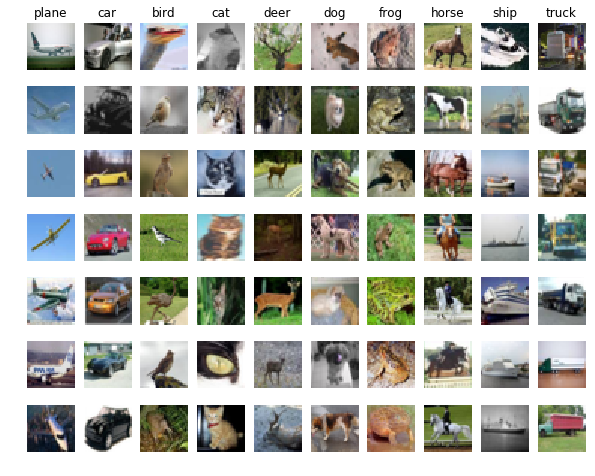

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne import init
from lasagne.layers import batch_norm
input_X = T.tensor4("X", dtype='float32')
target_y = T.vector("target Y integer",dtype='int32')

Using cuDNN version 5005 on context None
Preallocating 1603/2004 Mb (0.800000) on cuda0
Mapped name None to device cuda0: GeForce GT 740M (0000:01:00.0)


In [6]:

#1
net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
#2
net = batch_norm(lasagne.layers.Conv2DLayer(net, 32, 3, pad=1, nonlinearity=lasagne.nonlinearities.leaky_rectify))
#3
net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2), stride=2)
#4
net = batch_norm(lasagne.layers.Conv2DLayer(net, 64, 3, pad=1, nonlinearity=lasagne.nonlinearities.leaky_rectify))
#5
net = lasagne.layers.DropoutLayer(net, 0.5)
net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2), stride=2)
#6
net = batch_norm(lasagne.layers.Conv2DLayer(net, 128, 3, pad=1, nonlinearity=lasagne.nonlinearities.leaky_rectify))
#7
net = lasagne.layers.DropoutLayer(net, 0.5)

net = lasagne.layers.DenseLayer(net,num_units = 10, nonlinearity=softmax)
#net = lasagne.layers.Conv2DLayer(net, 10, 1, pad=1, nonlinearity=lasagne.nonlinearities.leaky_rectify)
#8
#9


In [7]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b]


In [8]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [9]:
updates = lasagne.updates.adam(loss, all_weights, learning_rate=0.01)
#updates = lasagne.updates.adadelta(loss, all_weights, learning_rate=0.01)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [10]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [12]:
import time

num_epochs = 20 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 20 took 83.688s
  training loss (in-iteration):		0.694003
  train accuracy:		76.01 %
  validation accuracy:		71.22 %
Epoch 2 of 20 took 86.937s
  training loss (in-iteration):		0.683479
  train accuracy:		76.39 %
  validation accuracy:		70.57 %
Epoch 3 of 20 took 83.889s
  training loss (in-iteration):		0.668703
  train accuracy:		76.71 %
  validation accuracy:		69.16 %
Epoch 4 of 20 took 84.659s
  training loss (in-iteration):		0.655213
  train accuracy:		77.14 %
  validation accuracy:		70.53 %
Epoch 5 of 20 took 83.879s
  training loss (in-iteration):		0.641005
  train accuracy:		77.59 %
  validation accuracy:		70.96 %
Epoch 6 of 20 took 83.784s
  training loss (in-iteration):		0.633284
  train accuracy:		77.83 %
  validation accuracy:		70.45 %
Epoch 7 of 20 took 83.818s
  training loss (in-iteration):		0.623677
  train accuracy:		78.28 %
  validation accuracy:		71.42 %
Epoch 8 of 20 took 83.756s
  training loss (in-iteration):		0.617319
  train accuracy:		78.27 %
  valida

In [25]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		71.87 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 